# Benchmark ClimateTimer performance in a search scenario

## Experiment Goal and Overview

This experiment aims to benchmark three different methods for searching a random point in time within a time-series DataFrame. Each row in the DataFrame represents a 15-minute time block. The experiment compares:

1. **Datetime Search using NumPy:**  
   Uses `np.searchsorted` on a sorted NumPy array of datetime values.

2. **ClimateTimer Index Search:**  
   Leverages the [ClimateTimer](https://pypi.org/project/climatetimer/) library to convert each timestamp to a block ID. The library is imported using:
   ```python
   from climatetimer import ClimateTimer
   timer = ClimateTimer("paris")
   ```
   The block ID is computed using `timer.blockid(…, blocktype="quarter")`, and the search is performed on the resulting integer array.

3. **Native Pandas Search:**  
   Uses pandas’ native slicing capability on a DataFrame with a `DatetimeIndex` (via `df.loc[time:time]`) to search for a period.

---

## Data Preparation

- **Time Series Generation:**  
  A DataFrame is generated where each row represents a 15-minute interval starting from a fixed date (e.g., `"2020-01-01"`).

- **Simulating Missing Data:**  
  For each DataFrame, 10% of the rows are randomly removed to simulate data gaps.

- **Index Calculation for ClimateTimer:**  
  Each timestamp is converted to a block ID using the ClimateTimer library. The conversion uses the `"quarter"` block type, which corresponds to 15-minute blocks.

---

## Performance Measurement

For each DataFrame size (ranging from 10 to 1,000,000 rows with increments roughly by a factor of 10), the following steps are performed:

1. **Random Search Point Generation:**  
   A random search time is selected between the minimum and maximum timestamps in the DataFrame.

2. **Timing Each Search Method:**  
   - **Datetime Search (using NumPy):**  
     Measures the time taken to locate the random datetime using `np.searchsorted` on a sorted array of datetime values.
   - **ClimateTimer Search:**  
     Converts the random time to a block ID using `timer.blockid()` and measures the time taken to search for this block ID in the integer array.
   - **Native Pandas Search:**  
     Uses native slicing with a `DatetimeIndex` (via `.loc`) to find the period corresponding to the random time.

3. **Repeating Trials:**  
   Each search method is executed over 1000 trials, and the average search time is computed for each method at each DataFrame size.

---

## Visualization

The average search times for each method are plotted on a log–log scale with the DataFrame size on the x-axis and the average search time (in seconds) on the y-axis. This visual comparison helps identify the performance characteristics and scalability of each search method.

---

This experiment will help determine whether using the ClimateTimer library (and its block ID conversion) offers a performance benefit over direct datetime searches and pandas’ native slicing as the dataset size grows.

---

In [ ]:
!pip install climatetimer==0.2.1

In [ ]:
!pip install pandas; numpy; random; time; matplotlib

In [34]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from climatetimer import ClimateTimer  # updated import

In [ ]:
# Instantiate ClimateTimer using the Paris Agreement reference.
timer = ClimateTimer("paris")

# Define DataFrame sizes (growing roughly by a factor of 10)
sizes = [10, 100, 1000, 10000, 100000, 1000000]
percent_remove = 0.1  # 10% of rows will be randomly removed
n_trials = 1000  # number of search trials per DataFrame size

# Lists to store the average search times for each method (for plotting)
datetime_search_times = []
climatetimer_search_times = []
native_search_times = []

In [36]:
for size in sizes:
    # Create a timezone-aware date range starting from a fixed time with 15-minute intervals.
    start_time = pd.Timestamp("2020-01-01", tz="UTC")
    full_dates = pd.date_range(start=start_time, periods=size, freq="15min")
    df = pd.DataFrame({"time": full_dates})

    # Randomly remove a percentage of rows.
    remove_indices = np.random.choice(df.index, size=int(size * percent_remove), replace=False)
    df = df.drop(remove_indices).reset_index(drop=True)

    # Ensure the DataFrame is sorted by time.
    df = df.sort_values("time").reset_index(drop=True)

    # Create a native search DataFrame with a DatetimeIndex.
    df_native = df.set_index("time")

    # Compute the ClimateTimer block ID for each timestamp.
    # Convert Pandas Timestamp to Python datetime with .to_pydatetime()
    df["climate_index"] = df["time"].apply(lambda t: timer.blockid(t.to_pydatetime(), blocktype="quarter"))

    # Convert columns to numpy arrays for fast search operations.
    times_array = df["time"].values
    climate_array = df["climate_index"].values

    dt_times = []  # datetime search via numpy
    ct_times = []  # ClimateTimer search via numpy on block IDs
    native_times = []  # native pandas search using .loc

    for _ in range(n_trials):
        # Generate a random search time between the minimum and maximum times.
        rand_time = df["time"].min() + (df["time"].max() - df["time"].min()) * random.random()

        # --- Datetime search using numpy ---
        # Remove timezone info from rand_time before conversion to np.datetime64
        start = time.perf_counter()
        _ = np.searchsorted(times_array, np.datetime64(rand_time.tz_localize(None)))
        end = time.perf_counter()
        dt_times.append(end - start)

        # --- ClimateTimer search ---
        # Round to microsecond precision to avoid nanosecond warnings
        rand_dt = rand_time.round("us").to_pydatetime()
        rand_block = timer.blockid(rand_dt, blocktype="quarter")
        start = time.perf_counter()
        _ = np.searchsorted(climate_array, rand_block)
        end = time.perf_counter()
        ct_times.append(end - start)

        # --- Native pandas search using .loc ---
        start = time.perf_counter()
        _ = df_native.loc[rand_time:rand_time]
        end = time.perf_counter()
        native_times.append(end - start)

    # Compute the average search times for the current DataFrame size.
    avg_dt = np.mean(dt_times)
    avg_ct = np.mean(ct_times)
    avg_native = np.mean(native_times)

    datetime_search_times.append(avg_dt)
    climatetimer_search_times.append(avg_ct)
    native_search_times.append(avg_native)

    # Build a resume table for this DataFrame size.
    metrics = [
        ("Datetime (np.searchsorted)", avg_dt),
        ("ClimateTimer search", avg_ct),
        ("Native pandas search", avg_native),
    ]

    # Sort the metrics by average execution time (fastest first)
    metrics_sorted = sorted(metrics, key=lambda x: x[1])
    fastest_time = metrics_sorted[0][1]

    print(f"\nDataFrame Size: {size}")
    print("-" * 80)
    print(f"{'Method':<30} {'Avg Time (sec)':>20} {'% Slower':>20}")
    for method, avg_time in metrics_sorted:
        percent_slower = 0.0 if method == metrics_sorted[0][0] else ((avg_time - fastest_time) / fastest_time) * 100
        print(f"{method:<30} {avg_time:>20.8f} {percent_slower:>19.2f}%")
    print("-" * 80)


DataFrame Size: 10
--------------------------------------------------------------------------------
Method                               Avg Time (sec)             % Slower
ClimateTimer search                      0.00000213                0.00%
Datetime (np.searchsorted)               0.00000469              119.83%
Native pandas search                     0.00002914             1266.27%
--------------------------------------------------------------------------------

DataFrame Size: 100
--------------------------------------------------------------------------------
Method                               Avg Time (sec)             % Slower
ClimateTimer search                      0.00000192                0.00%
Datetime (np.searchsorted)               0.00000413              115.78%
Native pandas search                     0.00002876             1401.05%
--------------------------------------------------------------------------------

DataFrame Size: 1000
-----------------------------

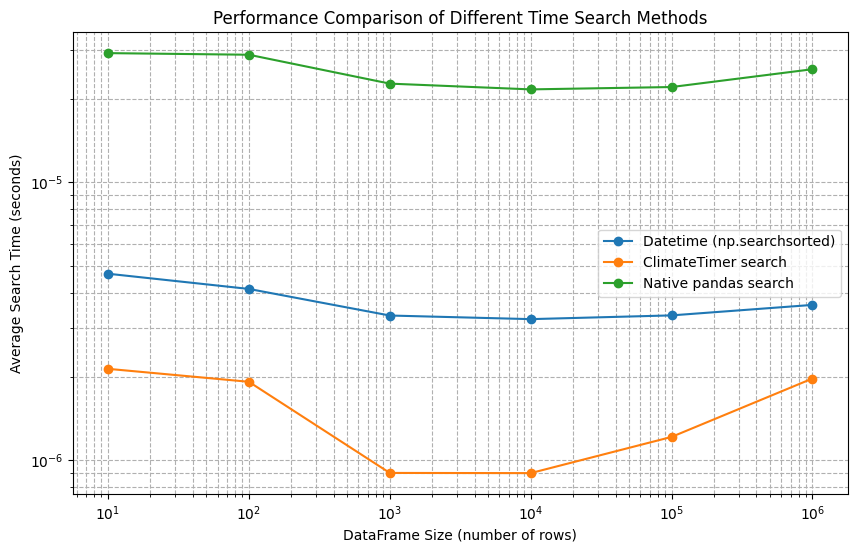

In [37]:
# Plot the results on a log-log scale.
plt.figure(figsize=(10, 6))
plt.plot(sizes, datetime_search_times, label="Datetime (np.searchsorted)", marker="o")
plt.plot(sizes, climatetimer_search_times, label="ClimateTimer search", marker="o")
plt.plot(sizes, native_search_times, label="Native pandas search", marker="o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("DataFrame Size (number of rows)")
plt.ylabel("Average Search Time (seconds)")
plt.title("Performance Comparison of Different Time Search Methods")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()